In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# make a folder to store figures if not already there
!mkdir ../jupyter_figures

mkdir: ../jupyter_figures: File exists


In [2]:
# For contorl condition, combine 3 datasets of normal SMGs (e.g., not treated with collagenase)
#
# Each file is from one data set with a track_id column and an interior_number column,
# which use number "1", "2" or "0" to indicate all three possible cell division outcomes

df1 = pd.read_csv('../data/cell-division-tracking-data/180218-mTmGHisG-2photon-cell-division-outcome.csv')
df1.track_id = ['180218_' + str(track_id) for track_id in df1.track_id]
df2 = pd.read_csv('../data/cell-division-tracking-data/190227-mTmGHisG-2_E13-1_denoised-BCratio-cell-division-outcome.csv')
df2.track_id = ['190227_' + str(track_id) for track_id in df2.track_id]
df3 = pd.read_csv('../data/cell-division-tracking-data/190331-4_K14Rhet-HisG-1-1-denoised-BCratio-stacked-t1-120-cell-division-outcome.csv')
df3.track_id = ['190331_' + str(track_id) for track_id in df3.track_id]

df = pd.concat([df1, df2, df3])
# df.head()

In [3]:
# Annotate cell division types based on the number of interior daughter cells
#
# Type 1: 2 interior daughters
# Type 2: 1 interior, 1 surface daughter
# Type 3: 2 surface daughter
# Type 4: 1 surface daughter, 1 extruded
# Type 5: 2 extruded
#
# Note: we use negative numbers here to represent the number of daughters extruded
# outward at anaphase onset. Only observed when basement membrane is disrupted.
#
division_type_dict = {'2': 'Type 1',
                      '1': 'Type 2',
                      '0': 'Type 3', 
                      '-1': 'Type 4',
                      '-2': 'Type 5'}

division_types = [ division_type_dict[str(df.number_interior.tolist()[i])]
                      for i in range(len(df)) ]
df['division_type'] = division_types

In [4]:
# Get summary stats

division_types = []
n_division_types = []
for key, value in division_type_dict.items():
    division_types.append(value)
    df_temp = df[df.division_type==value]
    n_division_types.append(df_temp.track_id.nunique())

N = np.sum(n_division_types)
print('Total cell divisions:', N)

ratio_division_types = n_division_types / N
print('Ratio of 5 types:', ratio_division_types)

Total cell divisions: 289
Ratio of 5 types: [0.92387543 0.07612457 0.         0.         0.        ]


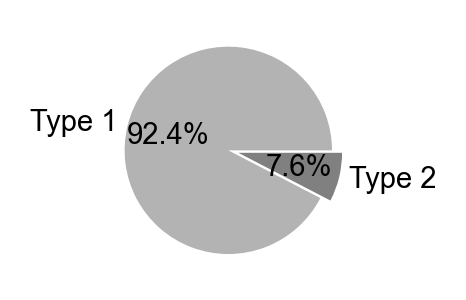

In [5]:
# Make pie chart to represent the proportion of the two cases (types)

fig_width, fig_height = 1, 1
fig_dpi = 300
fig = plt.figure(figsize=(fig_width, fig_height), dpi=fig_dpi)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = division_types[:2]
sizes = ratio_division_types[:2]
# explode = (0, 0.1)  # only "explode" the 2nd slice
explode = [0.05]*len(labels)
colors=['0.7', '0.5'] # gray values, the larger the lighter

ax.pie(sizes, explode=explode, labels=labels,
       autopct='%1.1f%%', colors=colors,
       shadow=False, startangle=0)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig('../jupyter_figures/control-cell-division-outcome-pie-chart.svg')


In [6]:
# Combine 3 datasets of collagenase treated SMGs

df1 = pd.read_csv('../data/cell-division-tracking-data/20210124-K14RhisG-2p-collagenase-SMG1-track-info.csv')
df1.track_id = ['210124_SMG1_' + str(track_id) for track_id in df1.track_id]
df2 = pd.read_csv('../data/cell-division-tracking-data/20210124-K14RhisG-2p-collagenase-SMG2-track-info.csv')
df2.track_id = ['210124_SMG2_' + str(track_id) for track_id in df2.track_id]
df3 = pd.read_csv('../data/cell-division-tracking-data/20210124-K14RhisG-2p-collagenase-SMG3-track-info.csv')
df3.track_id = ['210124_SMG3_' + str(track_id) for track_id in df3.track_id]

df = pd.concat([df1, df2, df3])
df.head()

,track_name,track_id,spot_id,x,y,z,t
0,0in1ex,210124_SMG1_1,852,74.090010,149.936688,42.0,153
1,0in1ex,210124_SMG1_1,858,74.296677,153.036688,42.0,152
2,0in1ex,210124_SMG1_4,880,51.976674,214.623363,40.0,213
3,0in1ex,210124_SMG1_4,883,57.350008,215.243363,40.0,212
4,0in1ex,210124_SMG1_8,921,271.663371,161.303356,56.0,171


<AxesSubplot:xlabel='track_name', ylabel='t'>

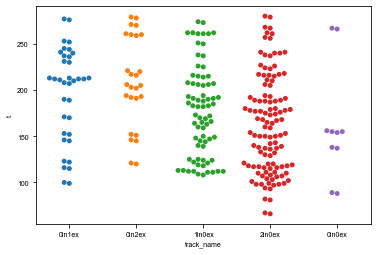

In [7]:
sns.swarmplot(df.track_name, df.t)

In [8]:
df.t.min()

66

In [9]:
# The track_name column contains the scored information of cell division types
# As the name indicates, '2in0ex' means 2 interior daughters,
# '0in2ex' means 2 extruded daughters etc.

division_type_dict = {'2in0ex': 'Type 1',
                      '1in0ex': 'Type 2',
                      '0in0ex': 'Type 3', 
                      '0in1ex': 'Type 4',
                      '0in2ex': 'Type 5'}

division_types = [ division_type_dict[df.track_name.tolist()[i]]
                      for i in range(len(df)) ]
df['division_type'] = division_types

In [10]:
# Get summary stats

division_types = []
n_division_types = []
for key, value in division_type_dict.items():
    division_types.append(value)
    df_temp = df[df.division_type==value]
    n_division_types.append(df_temp.track_id.nunique())

N = np.sum(n_division_types)
print('Total cell divisions:', N)

ratio_division_types = n_division_types / N
print('Ratio of 5 types:', ratio_division_types)

Total cell divisions: 130
Ratio of 5 types: [0.43846154 0.28461538 0.03846154 0.13846154 0.1       ]


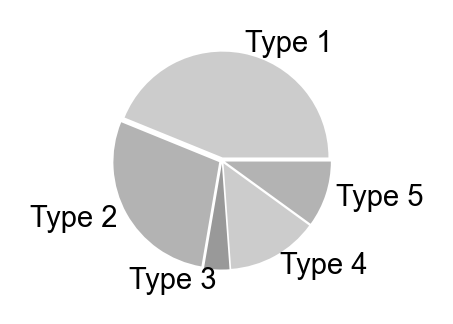

In [11]:
# Make pie chart to represent the proportion of the two cases (types)

fig_width, fig_height = 1, 1
fig_dpi = 300
fig = plt.figure(figsize=(fig_width, fig_height), dpi=fig_dpi)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = division_types
sizes = ratio_division_types
# explode = (0.1, 0.1, 0.1, 0.1, 0.1)
explode = [0.03]*5
colors=['0.8', '0.7', '0.6']

ax.pie(sizes, explode=explode,
       labels=labels, colors=colors,
#        autopct='%1.1f%%',
       shadow=False, startangle=0)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig('../jupyter_figures/collagenase-cell-division-outcome-pie-chart.svg')


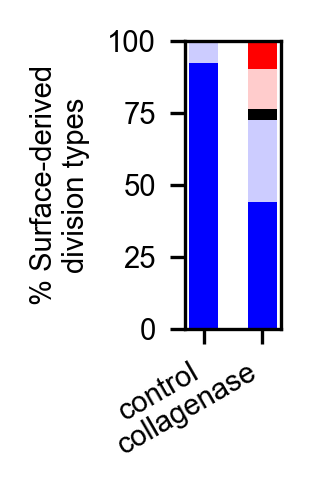

In [12]:
# stacked bar
# [0.43846154 0.28461538 0.03846154 0.13846154 0.1       ]
labels = ['control', 'collagenase']
type1 = [92.4, 43.84]
type2 = [7.6, 28.46]
type3 = [0, 3.85]
type4 = [0, 13.85]
type5 = [0, 10]

bottom1 = type1
bottom2 = [type1[i]+type2[i] for i in range(len(type1))]
bottom3 = [type1[i]+type2[i]+type3[i] for i in range(len(type1))]
bottom4 = [type1[i]+type2[i]+type3[i]+type4[i] for i in range(len(type1))]

fig_width, fig_height = .4, 1.2
fig_dpi = 300
fig = plt.figure(figsize=(fig_width, fig_height), dpi=fig_dpi)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# change bar width
width = 0.5

ax.bar(labels, type1, width,
       color = 'blue', alpha=1,
       label='Type 1')

ax.bar(labels, type2, width,
#        color = '.7',
       color = 'blue', alpha=.2,
       bottom=bottom1, label='Type 2')

ax.bar(labels, type3, width,
       color = 'black',
#        color = '.7',
       bottom=bottom2, label='Type 3')

ax.bar(labels, type4, width,
#        color = '.7',
       color = 'red', alpha=.2,
       bottom=bottom3, label='Type 4')

ax.bar(labels, type5, width,
       color = 'red', alpha=1,
       bottom=bottom4, label='Type 5')

# rotate x tick labels if necessary
# x_labels = ax.get_xticklabels()
x_labels = ['control', 'collagenase']
ax.set_xticklabels(labels=x_labels, rotation=30, ha="right")

# custome y label
plt.ylabel("% Surface-derived\ndivision types")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

outputFigPath = '../jupyter_figures/surface-division-types-control-collagenase-stacked-bar.svg'
plt.savefig(outputFigPath)


In [13]:
# single-cell culture
#
# Each file is from one data set with a track_id column and an interior_number column,
# which use number "1", "2" or "0" to indicate all three possible cell division outcomes

df = pd.read_csv('../data/cell-division-tracking-data/210201-mT-2p-2_single-cell-1d-mT.csv')
df.columns = ['track_id', 'number_interior']

In [14]:
df.head()

,track_id,number_interior
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


In [15]:
# Annotate cell division types based on the number of interior daughter cells
#
# Type 1: 2 interior daughters
# Type 2: 1 interior, 1 surface daughter
# Type 3: 2 surface daughter
# Type 4: 1 surface daughter, 1 extruded
# Type 5: 2 extruded
#
# Note: we use negative numbers here to represent the number of daughters extruded
# outward at anaphase onset. Only observed when basement membrane is disrupted.
#
division_type_dict = {'2': 'Type 1',
                      '1': 'Type 2',
                      '0': 'Type 3', 
                      '-1': 'Type 4',
                      '-2': 'Type 5'}

division_types = [ division_type_dict[str(df.number_interior.tolist()[i])]
                      for i in range(len(df)) ]
df['division_type'] = division_types

In [16]:
# Get summary stats

division_types = []
n_division_types = []
for key, value in division_type_dict.items():
    division_types.append(value)
    df_temp = df[df.division_type==value]
    n_division_types.append(df_temp.track_id.nunique())

N = np.sum(n_division_types)
print('Total cell divisions:', N)

ratio_division_types = n_division_types / N
print('Ratio of 5 types:', ratio_division_types)


Total cell divisions: 23
Ratio of 5 types: [0.56521739 0.43478261 0.         0.         0.        ]


In [17]:
# single-bud culture
#
# Each file is from one data set with a track_id column and an interior_number column,
# which use number "1", "2" or "0" to indicate all three possible cell division outcomes

df = pd.read_csv('../data/cell-division-tracking-data/210201-mT-2p-3_single-bud-0d-mT.csv')
df.columns = ['track_id', 'number_interior']

In [18]:
# Annotate cell division types based on the number of interior daughter cells
#
# Type 1: 2 interior daughters
# Type 2: 1 interior, 1 surface daughter
# Type 3: 2 surface daughter
# Type 4: 1 surface daughter, 1 extruded
# Type 5: 2 extruded
#
# Note: we use negative numbers here to represent the number of daughters extruded
# outward at anaphase onset. Only observed when basement membrane is disrupted.
#
division_type_dict = {'2': 'Type 1',
                      '1': 'Type 2',
                      '0': 'Type 3', 
                      '-1': 'Type 4',
                      '-2': 'Type 5'}

division_types = [ division_type_dict[str(df.number_interior.tolist()[i])]
                      for i in range(len(df)) ]
df['division_type'] = division_types

In [19]:
# Get summary stats

division_types = []
n_division_types = []
for key, value in division_type_dict.items():
    division_types.append(value)
    df_temp = df[df.division_type==value]
    n_division_types.append(df_temp.track_id.nunique())

N = np.sum(n_division_types)
print('Total cell divisions:', N)

ratio_division_types = n_division_types / N
print('Ratio of 5 types:', ratio_division_types)


Total cell divisions: 24
Ratio of 5 types: [0.70833333 0.29166667 0.         0.         0.        ]


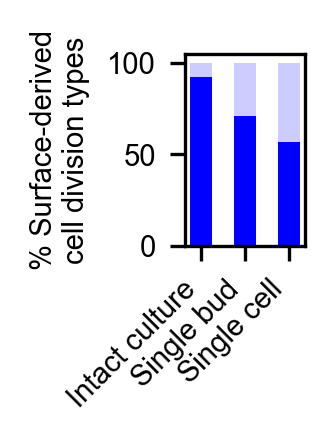

In [24]:
# stacked bar

labels = ['intact culture', 'single bud', 'single cell']
type1 = [92.4, 70.8, 56.5]
type2 = [7.6, 29.2, 43.5]

fig_width, fig_height = .5, .8
fig_dpi = 300
fig = plt.figure(figsize=(fig_width, fig_height), dpi=fig_dpi)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# change bar width
width = 0.5

ax.bar(labels, type1, width,
       color = 'blue', alpha=1,
       label='Type 1')
ax.bar(labels, type2, width,
#        color = '.7',
       color = 'blue', alpha=.2,
       bottom=type1, label='Type 2')

# rotate x tick labels if necessary
# x_labels = ax.get_xticklabels()
x_labels = ['Intact culture', 'Single bud', 'Single cell']
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

# custome y label
plt.ylabel("% Surface-derived\ncell division types")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

outputFigPath = '../jupyter_figures/surface-division-types-intact-culture-single-bud-single-cell-stacked-bar.svg'
plt.savefig(outputFigPath)
